## Práctica 3. Análisis de la varianza

### Librerías necesarias

In [1]:
import pandas as pd
import numpy as np
import random
import researchpy as rp
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp as mc
import matplotlib.pyplot as plt
import pingouin as pg
import seaborn as sns
import os
import warnings
from datetime import datetime

In [2]:
warnings.filterwarnings("ignore")

### Importar datos

In [3]:
path = '.\data\datos_2021.xlsx'
data_AGU = pd.read_excel(path, sheet_name='AGU')
data_ATM = pd.read_excel(path, sheet_name='ATM')
data_CEN = pd.read_excel(path, sheet_name='CEN')
data_PIN = pd.read_excel(path, sheet_name='PIN')
data_LDO = pd.read_excel(path, sheet_name='LDO')
data_MIR = pd.read_excel(path, sheet_name='MIR')
data_OBL = pd.read_excel(path, sheet_name='OBL')
data_SFE = pd.read_excel(path, sheet_name='SFE')
data_TLA = pd.read_excel(path, sheet_name='TLA')
data_VAL = pd.read_excel(path, sheet_name='VAL')

In [4]:
data = pd.concat([data_AGU, data_ATM, data_CEN, data_PIN, data_LDO, data_MIR, data_OBL, data_SFE, data_TLA, data_VAL])

In [5]:
data.rename(columns={'Estación SIMAJ':'estacion_simaj', 'Fecha':'fecha', 'Hora':'hora'}, inplace=True)

### Preparación de datos

In [6]:
data = data.astype({
    'estacion_simaj': 'string',
    'hora':'Int64'})

In [7]:
data['O3'] = pd.to_numeric(data['O3'],errors='coerce')
data['NO'] = pd.to_numeric(data['NO'],errors='coerce')
data['NO2'] = pd.to_numeric(data['NO2'],errors='coerce')
data['NOX'] = pd.to_numeric(data['NOX'],errors='coerce')
data['SO2'] = pd.to_numeric(data['SO2'],errors='coerce')
data['CO'] = pd.to_numeric(data['CO'],errors='coerce')
data['PM10'] = pd.to_numeric(data['PM10'],errors='coerce')
data['PM2.5'] = pd.to_numeric(data['PM2.5'],errors='coerce')
data['TMP'] = pd.to_numeric(data['TMP'],errors='coerce')
data['TMPI'] = pd.to_numeric(data['TMPI'],errors='coerce')
data['RH'] = pd.to_numeric(data['RH'],errors='coerce')
data['WS'] = pd.to_numeric(data['WS'],errors='coerce')
data['WD'] = pd.to_numeric(data['WD'],errors='coerce')
data['PP'] = pd.to_numeric(data['PP'],errors='coerce')
data['RS'] = pd.to_numeric(data['RS'],errors='coerce')
data['PBA'] = pd.to_numeric(data['PBA'],errors='coerce')
data['UV'] = pd.to_numeric(data['UV'],errors='coerce')
data['UVI'] = pd.to_numeric(data['UVI'],errors='coerce')

In [8]:
# Convertir la fecha en el formato de datos "datetime"
data['d_date'] = pd.to_datetime(data['fecha'], errors='coerce')

In [9]:
# Extraer el año, mes y día desde el "datetime"
data['anio'] = data.d_date.map(lambda x: x.year)
data['mes'] = data.d_date.map(lambda x: x.month)
data['dia'] = data.d_date.map(lambda x: x.day)

In [10]:
# Convertir el día en valor de día semanal
data['dia_semana'] = data['d_date'].dt.dayofweek

In [11]:
#Converir el data.type apropiado de acuerdo con la variable
data = data.astype({
    'anio': 'Int64',
    'mes':'string',
    'dia':'Int64',
    'dia_semana':'string'
})

### Análisis exploratorio de los datos

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87600 entries, 0 to 8759
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   estacion_simaj  87600 non-null  string        
 1   fecha           87600 non-null  object        
 2   hora            87600 non-null  Int64         
 3   O3              60121 non-null  float64       
 4   NO              33072 non-null  float64       
 5   NO2             33432 non-null  float64       
 6   NOX             33432 non-null  float64       
 7   SO2             52606 non-null  float64       
 8   CO              56928 non-null  float64       
 9   PM10            50684 non-null  float64       
 10  PM2.5           21214 non-null  float64       
 11  TMPI            74351 non-null  float64       
 12  TMP             52512 non-null  float64       
 13  RH              73296 non-null  float64       
 14  WS              71640 non-null  float64       
 15  WD 

In [13]:
#Reemplazar valores numéricos por valores en cadena
data['dia_semana'].replace({'0.0':'Lunes', '1.0':'Martes', '2.0':'Miercoles', '3.0':'Jueves', '4.0':'Viernes', '5.0':'Sabado', '6.0':'Domingo'},
                          inplace=True)

In [14]:
#Reemplazar valores numéricos por valores en cadena
data['mes'].replace({'1.0':'Enero', '2.0':'Febrero', '3.0':'Marzo', '4.0':'Abril', '5.0':'Mayo', '6.0':'Junio', '7.0':'Julio', '8.0':'Agosto',
                    '9.0':'Septiembre', '10.0':'Octubre', '11.0':'Noviembre', '12.0':'Diciembre'}, inplace=True)

In [15]:
data.head(5)

,estacion_simaj,fecha,hora,O3,NO,NO2,NOX,SO2,CO,PM10,...,PP,RS,PBA,UV,UVI,d_date,anio,mes,dia,dia_semana
0,Aguilas,2021-01-01 00:00:00,0,0.004,NaN,NaN,NaN,0.0016,1.528,NaN,...,0.0,NaN,NaN,NaN,NaN,2021-01-01 00:00:00,2021,Enero,1,Viernes
1,Aguilas,2021-01-01 01:00:00,1,0.003,NaN,NaN,NaN,0.0000,0.000,NaN,...,0.0,NaN,NaN,NaN,NaN,2021-01-01 01:00:00,2021,Enero,1,Viernes
2,Aguilas,2021-01-01 02:00:00,2,0.000,NaN,NaN,NaN,0.0029,1.683,NaN,...,0.0,NaN,NaN,NaN,NaN,2021-01-01 02:00:00,2021,Enero,1,Viernes
3,Aguilas,2021-01-01 03:00:00,3,0.000,NaN,NaN,NaN,0.0021,1.387,NaN,...,0.0,NaN,NaN,NaN,NaN,2021-01-01 03:00:00,2021,Enero,1,Viernes
4,Aguilas,2021-01-01 04:00:00,4,0.002,NaN,NaN,NaN,0.0025,1.207,NaN,...,0.0,NaN,NaN,NaN,NaN,2021-01-01 04:00:00,2021,Enero,1,Viernes


### Crear dataset de muestra

In [16]:
# Dejar únicamente las variables de interés
sample_data = data[['estacion_simaj', 'dia_semana', 'mes', 'hora','TMP']]

In [17]:
# Quitar "nan" del conjunto de datos
sample_data = sample_data.dropna().reset_index(drop=True)

In [18]:
# Quitar ceros
sample_data = sample_data[sample_data['TMP'] !=0]

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'Aguilas'),
  Text(1, 0, 'Atemajac'),
  Text(2, 0, 'Centro'),
  Text(3, 0, 'Las Pintas'),
  Text(4, 0, 'Miravalle'),
  Text(5, 0, 'Oblatos'),
  Text(6, 0, 'Santa Fe'),
  Text(7, 0, 'Vallarta')])

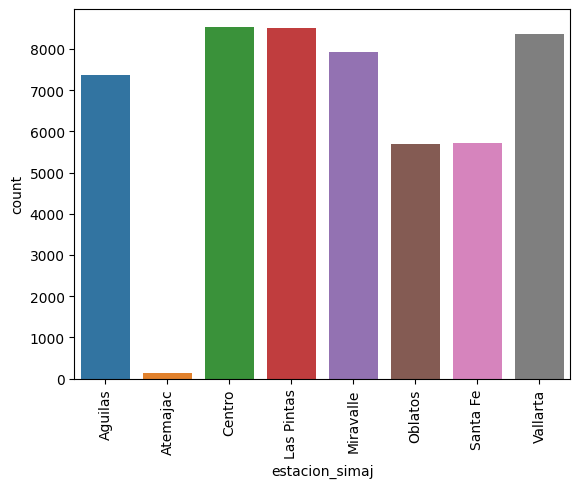

In [19]:
cplot = sns.countplot(x=sample_data["estacion_simaj"])
plt.xticks(rotation=90)

In [20]:
#Crear muestras
sample_AGU=sample_data[sample_data['estacion_simaj'] == 'Aguilas'].sample(100)
sample_ATM=sample_data[sample_data['estacion_simaj'] == 'Atemajac'].sample(100)
sample_CEN=sample_data[sample_data['estacion_simaj'] == 'Centro'].sample(100)
sample_PIN=sample_data[sample_data['estacion_simaj'] == 'Las Pintas'].sample(100)
#sample_LDO=sample_data[sample_data['estacion_simaj'] == 'Loma Dorada'].sample(100)
sample_MIR=sample_data[sample_data['estacion_simaj'] == 'Miravalle'].sample(100)
sample_OBL=sample_data[sample_data['estacion_simaj'] == 'Oblatos'].sample(100)
sample_SFE=sample_data[sample_data['estacion_simaj'] == 'Santa Fe'].sample(100)
#sample_TLA=sample_data[sample_data['estacion_simaj'] == 'Tlaquepaque'].sample(100)
sample_VAL=sample_data[sample_data['estacion_simaj'] == 'Vallarta'].sample(100)

In [21]:
sample = pd.concat([sample_AGU, sample_ATM, sample_CEN, sample_PIN,sample_MIR,sample_OBL,sample_SFE,sample_VAL])

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'Aguilas'),
  Text(1, 0, 'Atemajac'),
  Text(2, 0, 'Centro'),
  Text(3, 0, 'Las Pintas'),
  Text(4, 0, 'Miravalle'),
  Text(5, 0, 'Oblatos'),
  Text(6, 0, 'Santa Fe'),
  Text(7, 0, 'Vallarta')])

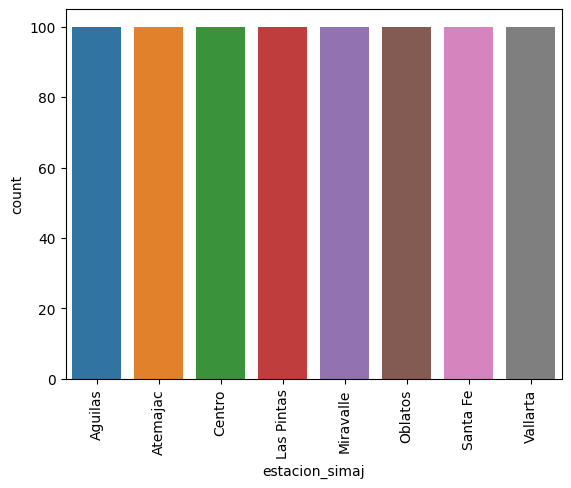

In [22]:
cplot = sns.countplot(x=sample["estacion_simaj"])
plt.xticks(rotation=90)

<AxesSubplot: title={'center': 'TMP'}, xlabel='estacion_simaj'>

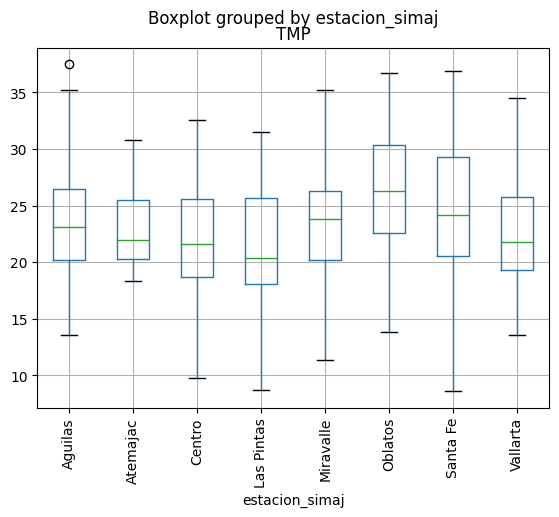

In [23]:
groups = sample.groupby('estacion_simaj').count().reset_index()
res=rp.summary_cont(sample['TMP'].groupby(sample['estacion_simaj']))
sample.boxplot('TMP',by='estacion_simaj',rot=90)

# Supuestos

### a) Normalidad

In [24]:
# Normalidad prueba de Shapiro-Wilk

#Ho:Normalidad(p>0.05)
#H1: No normalidad (p<0.05)

#Normalidad en las variables
pg.normality(sample, dv='TMP', group='estacion_simaj')

,W,pval,normal
Aguilas,0.980843,0.154565,True
Atemajac,0.916414,0.000009,False
Centro,0.989157,0.596987,True
Las Pintas,0.968114,0.015884,False
Miravalle,0.987741,0.489331,True
Oblatos,0.984686,0.301388,True
Santa Fe,0.984266,0.280834,True
Vallarta,0.971445,0.028549,False


In [25]:
# Varianza entre grupos
sample.groupby('estacion_simaj')['TMP'].var()

estacion_simaj
Aguilas       24.925257
Atemajac      11.541555
Centro        21.883728
Las Pintas    31.253474
Miravalle     25.168900
Oblatos       25.280683
Santa Fe      40.693754
Vallarta      19.509091
Name: TMP, dtype: float64

### Homocedasticidad

In [26]:
#Homocedasticidad prueba de Levene (sin normalidad)
#Ho:Homocedasticidad (p>0.05)
#H1: No Homocedasticidad (p<0.05)
pg.homoscedasticity(sample, dv='TMP', 
                    group='estacion_simaj',method='levene')

,W,pval,equal_var
levene,5.44299,0.000004,False


In [27]:
#Homocedasticidad prueba de Bartlett (con normalidad)
#Ho:Homocedasticidad (p>0.05)
#H1: No Homocedasticidad (p<0.05)
pg.homoscedasticity(sample, dv='TMP', 
                    group='estacion_simaj',method='bartlett')

,T,pval,equal_var
bartlett,43.291408,2.930126e-07,False


### Prueba one-way ANOVA

In [28]:
#%% One way ANOVA
model = ols('TMP ~ estacion_simaj', data=sample).fit()
#anova_table = sm.stats.anova_lm(model,typ=2)
#print(anova_table)

TypeError: Cannot interpret 'string[python]' as a data type

### Pruebas poshoc

In [29]:
#%%Comparación múltiple Prueba de Tukey
comp = mc.MultiComparison(sample_data['TMP'],sample_data['estacion_simaj'])
post_hoc_res = comp.tukeyhsd()
print(post_hoc_res.summary())

    Multiple Comparison of Means - Tukey HSD, FWER=0.05     
  group1     group2   meandiff p-adj   lower   upper  reject
------------------------------------------------------------
   Aguilas   Atemajac  -0.8355 0.5195 -2.1374  0.4664  False
   Aguilas     Centro  -1.8662    0.0 -2.1121 -1.6202   True
   Aguilas Las Pintas  -2.8215    0.0 -3.0677 -2.5753   True
   Aguilas  Miravalle    0.013    1.0 -0.2372  0.2633  False
   Aguilas    Oblatos   1.8645    0.0  1.5915  2.1376   True
   Aguilas   Santa Fe   0.2982 0.0205  0.0258  0.5707   True
   Aguilas   Vallarta  -0.8893    0.0 -1.1365 -0.6421   True
  Atemajac     Centro  -1.0307 0.2398 -2.3308  0.2695  False
  Atemajac Las Pintas   -1.986 0.0001 -3.2862 -0.6858   True
  Atemajac  Miravalle   0.8485 0.4976 -0.4525  2.1495  False
  Atemajac    Oblatos      2.7    0.0  1.3945  4.0056   True
  Atemajac   Santa Fe   1.1337 0.1443 -0.1717  2.4392  False
  Atemajac   Vallarta  -0.0538    1.0 -1.3542  1.2466  False
    Centro Las Pintas  -

### Two-ways ANOVA

In [ ]:
#Ho:m1=m2=m3+.... (p>0.05)
#H1: mi dif mj (p<0.05)

#model =ols('TMP ~ estacion_simaj + dia_semana ', data=sample_data).fit()
#anova_table = sm.stats.anova_lm(model,typ=2)
#print(anova_table)

#variables independientes: "major" y "gender"

In [ ]:
#%% Interacción entre variables
#model =ols('TMP ~ estacion_simaj:dia_semana', data=sample_data).fit()
#anova_table = sm.stats.anova_lm(model,typ=2)
#print(anova_table)

#si quieres conocer la interacción entre variables, debemos hacer esta forma y no la anterior

In [ ]:
#%% Prueba de Tukey (HSD)
#interaction_groups = "Major" + sample_data.major.astype(str) + " & " + "Gender" + sample_data.gender.astype(str)
#comp = mc.MultiComparison(sample_data["salary"], interaction_groups)
#post_hoc_res = comp.tukeyhsd()
#print(post_hoc_res.summary())

### Pruebas no paramétricas

In [30]:
#Kruskal Wallis
from scipy import stats
import scikit_posthocs as sp

In [31]:
group1=np.array(sample_AGU['TMP'])
group2=np.array(sample_ATM['TMP'])
group3=np.array(sample_CEN['TMP'])
group4=np.array(sample_PIN['TMP'])
group5=np.array(sample_MIR['TMP'])
group6=np.array(sample_OBL['TMP'])
group7=np.array(sample_SFE['TMP'])
group8=np.array(sample_VAL['TMP'])

In [32]:
stats.kruskal(group1, group2, group3, group4, group5, group6, group7, group8)

KruskalResult(statistic=63.54815664885369, pvalue=2.942443496897009e-11)

In [33]:
x=np.array([group1, group2, group3, group4, group5, group6, group7, group8])
pht=sp.posthoc_conover(x, p_adjust='bonferroni')